# Post Analysis, after GEANt4 Simulation

## Imports and stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=12,8
plt.rcParams.update({'font.size': 22})
plt.rcParams['lines.linewidth'] = 2


This is the nubmer of detectors

In [2]:
N=4

Make sure you have the following files in you directory:
'rossi_nt_Neutron Mul.csv'   
'rossi_nt_Gamma E.csv'    'rossi_nt_Neutron Occ.csv'   
'rossi_nt_Gamma Mul.csv'   'rossi_nt_Neutron E.csv'   rossi_nt_rossi.csv


In [5]:
ls *.csv

 pulse_train.csv          'rossi_nt_Neutron E.csv'     rossi_nt_rossi.csv
'rossi_nt_Gamma E.csv'    'rossi_nt_Neutron Mul.csv'
'rossi_nt_Gamma Mul.csv'  'rossi_nt_Neutron Occ.csv'


In [4]:
cd /home/yuval/software/my_simulations/

/home/yuval/software/my_simulations


## Merge Pulses close int time

In [6]:
def merge_pulses(indices,times,window,energies,thresh):
    """
    This function gets the detecor indices, times of steps, 
    time window, the energies of the steps and energy threshold fo neutron and gammas as list [E1,E2]
    It returns a dictionary of each detector and the genrated pulses in it, with their time and energ
    """
    pulses=dict()
    times=np.array(list(map(float,times)))
    energies=np.array(list(map(float,energies)))
    indices=np.array(list(map(int,indices)))
    
    
    for i in range(N):
        pulses[i]=np.column_stack((times[indices==i], energies[indices==i]))
        pulses[i]=pulses[i][pulses[i][:,0].argsort()]
    
    min_e=0.1e-3
    
    for key in pulses.keys():
        temp_time=np.array([])
        temp_energy=np.array([])
        det_pulses=pulses[key]
        
        det_pulses = det_pulses[det_pulses[:,1]>min_e,:]
        if len(det_pulses)==0:
            continue
        temp_time_array=[]
        for i in range(det_pulses.shape[0]):
            if i==0:
                #temp_time=np.append(temp_time,det_pulses[0,0])
                temp_energy=np.append(temp_energy,det_pulses[0,1])
                temp_time_array=[det_pulses[0,0]]
            #elif (det_pulses[i,0]-temp_time[-1])>window:
            elif (det_pulses[i,0]-det_pulses[i-1,0])>window:
                #temp_time=np.append(temp_time,det_pulses[i,0])
                temp_time=np.append(temp_time,np.mean(temp_time_array))
                temp_time_array=[det_pulses[i,0]]
                
                temp_energy=np.append(temp_energy,det_pulses[i,1])
            else:
                temp_energy[-1]+=det_pulses[i,1]
        if len(temp_time_array)>0:
            temp_time=np.append(temp_time,np.mean(temp_time_array))
        t_e_mat=np.column_stack((temp_time, temp_energy))
        pulses[key]=t_e_mat[t_e_mat[:,1]>thresh]
        
        """
        print(pulses[key])
        print("-----")
    print("-@@-@@-@@-@@-@@-")"""
    return pulses


## Definitions

In [7]:
energy_threshold=[0.4,1.6] #Energy Threshold for Gamma detection and for Neutron Detection in MeV
window=20e-9#Time Window. The code merges each pair of pulses that the separtion in time between them is smaller than this value
mass = 1e-9 #mass of the sample in grams
#rate_fission=3.092*1e-2*19.85e12 *mass #rate of fission events per second
#rate = 19.85e12*mass #rate of the decays in secondss
rate = 185e3 #5muCurie in Bq
eff = 21668/1000000 #global efficiency (from GEANT4)

## Initializations- load files

In [8]:
c_names=["Time Gamma","Energy Gamma", "Id Gamma","Track ID Gamma","Time Neutron","Energy Neutron","Id Neutron","Track ID Neutron"]
df = pd.read_csv('rossi_nt_rossi.csv',sep=',',   header=12, names=c_names)

from sklearn.utils import shuffle
#df = shuffle(df)
df.head()

,Time Gamma,Energy Gamma,Id Gamma,Track ID Gamma,Time Neutron,Energy Neutron,Id Neutron,Track ID Neutron
0,NaN,NaN,NaN,NaN,1.19621e-09;1.30498e-09,0.620387;3.50473,0;0,15;15
1,NaN,NaN,NaN,NaN,5.54608e-09;1.16228e-08;1.28335e-08,0.19198;0.128958;0.000580865,0;0;0,11;11;11
2,1.99312e-10,0.204035,3,4,2.01635e-09,1.95743,1,12
3,1.94098e-10;1.86724e-10,0.0211664;0.622672,1;3,4;8,NaN,NaN,NaN,NaN
4,1.47512e-10;1.87004e-10,0.206972;0.100286,1;3,8;6,3.30335e-09;4.25117e-09;1.88599e-09;2.29064e-09,0.276028;0.46536;1.69027;2.46207,2;2;3;3,10;10;13;13


## Merging the Pulses
Returns final_* arrays with the final pulses energy, times,detector ids and if they are neutrons or gammas

In [11]:
t_global=np.float128(0.0)
particles_names=["Gamma","Neutron"]
det_id=[]
final_pulses_times=np.array([])
final_pulses_energy=np.array([])
final_pulses_id=np.array([])
final_pulses_isN=np.array([])
final_pulses_real_times=np.array([])

cross_talk =0
for i in range(df.shape[0]):
    if (i%10000==0):
        print('Percent of Progress:',round(i/df.shape[0]*100),'%')
    while np.random.rand(1)[0]>eff:
        t_global+=np.float128(np.random.exponential(1/rate))
    t_global+=np.float128(np.random.exponential(1/rate))
    
    for particle_i in range(0,2):
        particle_name=particles_names[particle_i]
        row=df.iloc[i]
        time=row["Time "+particle_name]
        if isinstance(time,str):
            energy=row["Energy "+particle_name].split(";")
            det_index=row["Id "+particle_name].split(";")
            time=row["Time "+particle_name].split(";")
            track_ids = row["Track ID "+particle_name].split(";")
            
            for track_i ,t_id in enumerate(track_ids):
                for track_j in range(track_i+1,len(track_ids)):
                    if det_index[track_i]!= det_index[track_j] and t_id == track_ids[track_j] and float(energy[track_i])> energy_threshold[particle_i] and float(energy[track_j])> energy_threshold[particle_i] :
                        cross_talk+=1
                        #print(det_index[track_i],det_index[track_j],particle_name,energy,t_id,track_ids[track_j])

                    
            
            final_pulses=merge_pulses(det_index,time,window,energy,energy_threshold[particle_i])
             
            for key, item in final_pulses.items():
                if (item.size>0):
                    
                    time_row=np.float128(item[:,0]+t_global)
                    final_pulses_times=np.concatenate([final_pulses_times,time_row])
                    final_pulses_real_times=np.concatenate([final_pulses_real_times,item[:,0]])
                    final_pulses_energy=np.concatenate([final_pulses_energy,item[:,1]])
                    final_pulses_id=np.concatenate([final_pulses_id,key*np.ones(time_row.size)])
                    final_pulses_isN=np.concatenate([final_pulses_isN,(particle_name=="Neutron")*np.ones(time_row.size)])

final_pulses_times=final_pulses_times*1e9 #to ns
final_pulses_real_times=final_pulses_real_times*1e9 
print(cross_talk)

Percent of Progress: 0 %
Percent of Progress: 5 %
Percent of Progress: 9 %
Percent of Progress: 14 %
Percent of Progress: 19 %
Percent of Progress: 23 %
Percent of Progress: 28 %
Percent of Progress: 32 %
Percent of Progress: 37 %
Percent of Progress: 42 %
Percent of Progress: 46 %
Percent of Progress: 51 %
Percent of Progress: 56 %
Percent of Progress: 60 %
Percent of Progress: 65 %
Percent of Progress: 70 %
Percent of Progress: 74 %
Percent of Progress: 79 %
Percent of Progress: 84 %
Percent of Progress: 88 %
Percent of Progress: 93 %
Percent of Progress: 97 %
3


In [17]:
dt = final_pulses_times[1:]-final_pulses_times[:-1]
in_window = dt<20e-9
np.sum(final_pulses[1:][in_window] != final_pulses_id[:-1][in_window])

1073

In [75]:
final_pulses_times[-1]/1e9

53.654685803998631854

In [76]:
print(t_global,'Seconds')

53.655921444837027207 Seconds


## Saves The results to a files

In [32]:
titles=["Time (ns)","Energy(MeV)","Detector ID", "IsNeutron"]
df_final=pd.DataFrame(np.column_stack((final_pulses_times,final_pulses_energy,final_pulses_id,final_pulses_isN)),columns=titles)
df_final=df_final.sort_values(by="Time (ns)")
df_final.to_csv("pulse_train.csv")

## Singles, Doubles Triples

Here we are calculating the singles. The code here is a bit complicated because it need to take into account cases where two succsesive events are detected in the same detector within the integration window (defined as window). 
In this case, its count the as one.

In [33]:
times=df_final["Time (ns)"].values
det_id=df_final["Detector ID"].values
counts=0
for i in range(len(times)):
    same_det_count =np.sum(np.logical_and(times[i+1:]-times[i]<window*1e9,det_id[i+1:]==det_id[i])) 
    counts+=1-same_det_count
singles_rate= counts/(times[-1]*1e-9)
print('Singles rate: {:e} +- {:e} Hz'.format(singles_rate,np.sqrt(counts)/(times[-1]*1e-9)))

Singles rate: 1.460520e+03 +- 1.647599e+01 Hz


Here I calculate the rate of doubles and triples. Their correlation window is defined with doubles_window. Again I treat events in the same detector in less than 20 ns a one event.
To count the triple, I import here the combinatoric function choose.

In [34]:
from math import comb as nchoosek

doubles = 0

triples = 0
doubles_window = 20 #ns
for i in range(len(times)):

    
    id_condition = (times[i+1:]-times[i])<doubles_window
    id_same_det = np.logical_and(id_condition,det_id[i+1:]==det_id[i])
    same_det_in_int_window = np.sum((times[i+1:][id_same_det]-times[i])<window*1e9)
    
    dobules_in_window = np.sum(id_condition)-same_det_in_int_window #this variable represents the number of unique events i nthe specified time window, after a specific event
    doubles+=dobules_in_window
    if dobules_in_window>=2:
        triples += nchoosek(dobules_in_window,2)
    
print("Dobules Rate: {:e} +- {:e} Hz".format(doubles/(times[-1]*1e-9),np.sqrt(doubles)/(times[-1]*1e-9)))
print("Triples Rate: {:e} +- {:e} Hz".format(triples/(times[-1]*1e-9),np.sqrt(triples)/(times[-1]*1e-9)))

Dobules Rate: 1.284321e+02 +- 4.885786e+00 Hz
Triples Rate: 5.575922e+00 +- 1.018019e+00 Hz


## S,D,T As function of Activity

In [ ]:
rates = np.array([1.85E+05, 9.25E+04, 4.63E+04, 3.70E+05, 7.40E+05, 1.48E+06, 1.85e5*1e3,1.85E+07,1.85e5*3e2, 1.85e5*1e4,1.85e5*1e5,1.85e5/10])*2.7027e-5
singles =np.array([1.48E+03,7.39E+02,3.70E+02,2.95E+03,5.89E+03,1.18E+04,1.46E+06,1.47E+05,4.40E+05,1.333754e+07,3.089161e+06,1.467023e+02])
doubles = np.array([1.32E+02,6.60E+01,3.30E+01,2.63E+02,5.26E+02,1.05E+03, 1.63E+05,1.35E+04,4.19E+04,4.317000e+06,3.179411e+08,1.308583e+01])
triples = np.array([6.17E+00,3.087305,1.543648,1.23E+01,2.46E+01,4.95E+01,1.13E+04,6.60E+02,2.13E+03,8.029890e+05,3.619952e+08,6.125281e-01])

rates_s = np.argsort(rates)
rates, singles,doubles,triples = rates[rates_s], singles[rates_s],doubles[rates_s],triples[rates_s]

plt.figure()
plt.plot(rates,singles,'-*')
plt.xlabel(r"Activity ($\mu$Ci)")
plt.ylabel("Singles Rate")
plt.xscale('log')
plt.yscale('log')
plt.figure()
plt.plot(rates,doubles,'-*')
plt.xlabel(r"Activity ($\mu$Ci)")
plt.ylabel("Doubles Rate")
plt.xscale('log')
plt.yscale('log')
plt.figure()
plt.plot(rates,triples,'-*')
plt.xlabel(r"Activity ($\mu$Ci)")
plt.ylabel("Triples Rate")
plt.xscale('log')
plt.yscale('log')

We can see in the fraphs above the the linearity in the doubles and triples breaks around 10^3 micro cuire. We note that we assumed here paralyzable model for the dead time.

In [ ]:
rates_small = rates<10**3 # smaller then 1 milicuire
fit_res = np.polyfit(rates[rates_small],singles[rates_small],1)
fit_res[0]*110.9+fit_res[1]

In [ ]:
fit_res[0]*0.5+fit_res[1]

## Estimate activity based on simulation fit

In [56]:
def estimate_252Cf_activitiy_from_sdt( sdt,delta_sdt,fit_res = [293.98351745,  10.69035434], sdt_sim = [1.480901e+03, 1.321711e+02, 6.183223e+00],delta_sdt_sim=[7.449522e+00,2.225531e+00,4.813632e-01]):
    """
    Estimates the activity in muCuire based on the simulation. Returns the estimated activity based on the singles rates.
    makes sure that the S/D and S/T are within 1 percent as the simulation result for 5 micro cuire.
    """
    from scipy.stats import chi2

    
    s,d,t = sdt[0],sdt[1],sdt[2]
    ds,dd,dt = delta_sdt[0],delta_sdt[1],delta_sdt[2]
    
    s_sim,d_sim,t_sim = sdt_sim[0],sdt_sim[1],sdt_sim[2]
    ds_sim , dd_sim, dt_sim = delta_sdt_sim[0],delta_sdt_sim[1],delta_sdt_sim[2]
    est_activity = (s- fit_res[1])/fit_res[0]
    
    d_est,d_est_err = d_sim/s_sim*s, dd_sim/s_sim*s #Assumes singles uncertenity is much lower then doubles, assumes lineraity as well
    t_est, t_est_err = t_sim/s_sim*s, dt_sim/s_sim*s #Assumes singles uncertenity is much lower then triples, assumes lineraity as well
    
    
    
    chisq = np.abs(d_est-d)/np.sqrt(d_est_err**2+dd**2)+np.abs(t_est-t)/np.sqrt(t_est_err**2+dt**2)
    P_prob = 1-chi2.cdf(chisq,2)
    print (f'P prob: {P_prob}')
    return est_activity, P_prob

In [57]:
estimate_252Cf_activitiy_from_sdt([1.48E+03,1.32E+02,6.17E+00],[0,0,0])

P prob: 0.9702324518987663


(4.997932055527216, 0.9702324518987663)

#### Doubles and triples ratio

In [120]:
print(f"Doubles/Singles for 5muCi: {doubles[0]/singles[0]}")
print(f"Triples/Singles for 5muCi: {triples[0]/singles[0]}")

Doubles/Singles for 5muCi: 0.0891891891891892
Triples/Singles for 5muCi: 0.004168918918918919


## Rossi Alpha distribution calculation

In [14]:
df_final.head()
times_ralpha=times[0:int(len(times)/5)] #only 20 percent of the samples
diff_len=int((len(times_ralpha)-1+1)*(len(times_ralpha)-1-1+1)/2)
diff=np.float128(np.zeros((diff_len,1)))
diff_i=0
for i in range(len(times_ralpha)-1):
    if (i%1000==0):
        print(round(i/len(times_ralpha)*100),'%')
    for j in range(i+1,len(times_ralpha)):
        if (det_id[j]!=det_id[i] or (det_id[j]==det_id[i] and (times_ralpha[j]-times_ralpha[i])>window*1e9)):
            diff[diff_i]=times_ralpha[j]-times_ralpha[i]
            diff_i+=1


0 %
12 %
25 %
37 %
50 %
62 %
74 %
87 %
99 %


0.18047673098751418


Text(0.5, 1.0, 'Rossi alpha of t< 1 ms')

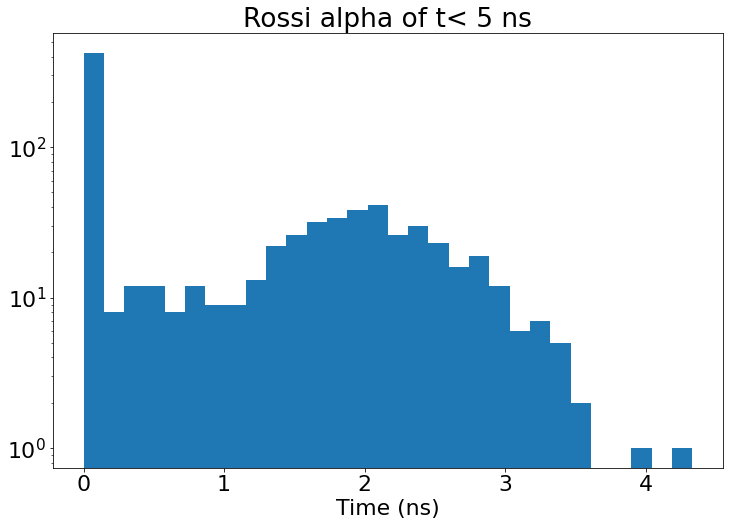

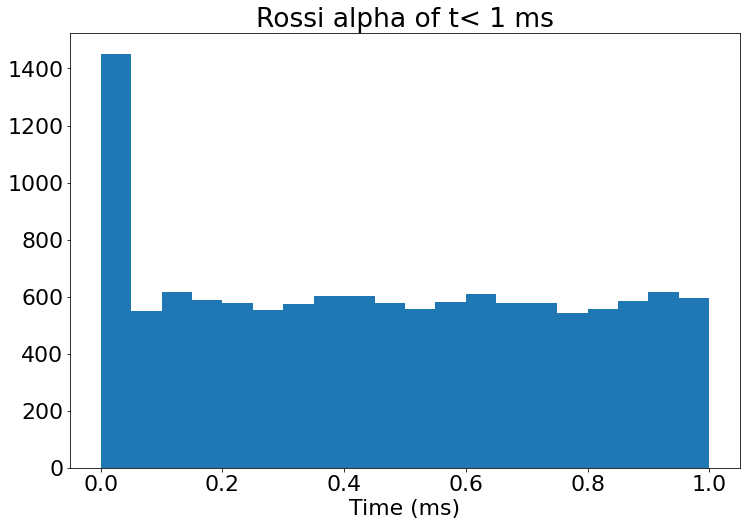

In [27]:
plt.figure()
plt.hist(diff[diff<5],bins=30);
plt.yscale('log')
plt.xlabel('Time (ns)')
plt.title('Rossi alpha of t< 5 ns')
print(np.sum(diff==0)/np.sum(diff<2000))

plt.figure()
plt.hist(1e-6*diff[diff<1e6],bins=20);
#plt.yscale('log')
plt.xlabel('Time (ms)')
plt.title('Rossi alpha of t< 1 ms')

## Plot Some results

Text(0, 0.5, 'Neutron Energy (MeV)')

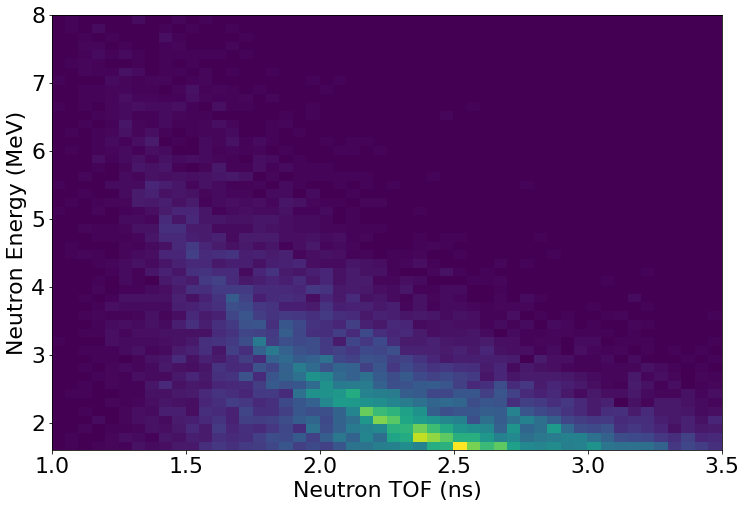

In [20]:
plt.figure()
plt.hist2d(final_pulses_real_times[final_pulses_isN==1],final_pulses_energy[final_pulses_isN==1],bins=50,range=[(1,3.5),(1.6,8)]);
plt.xlabel('Neutron TOF (ns)')
plt.ylabel('Neutron Energy (MeV)')

Text(0.5, 0, 'TOF (ns)')

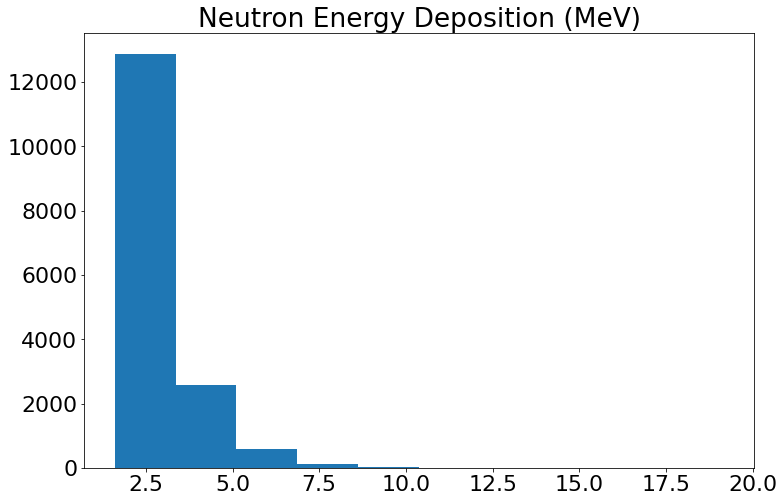

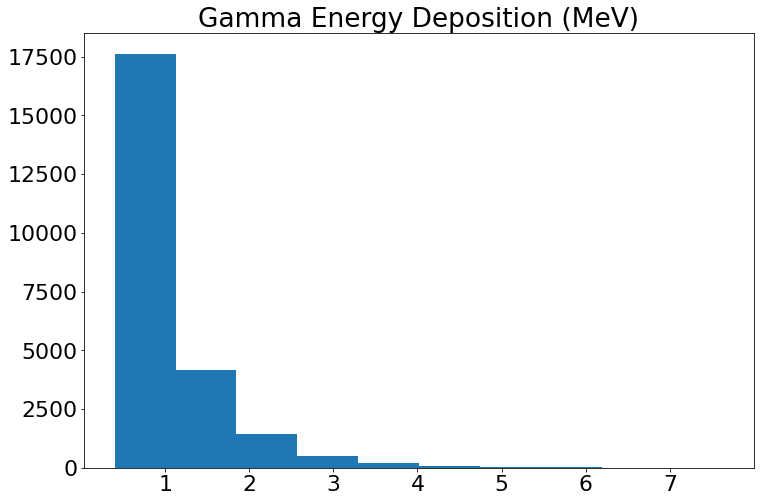

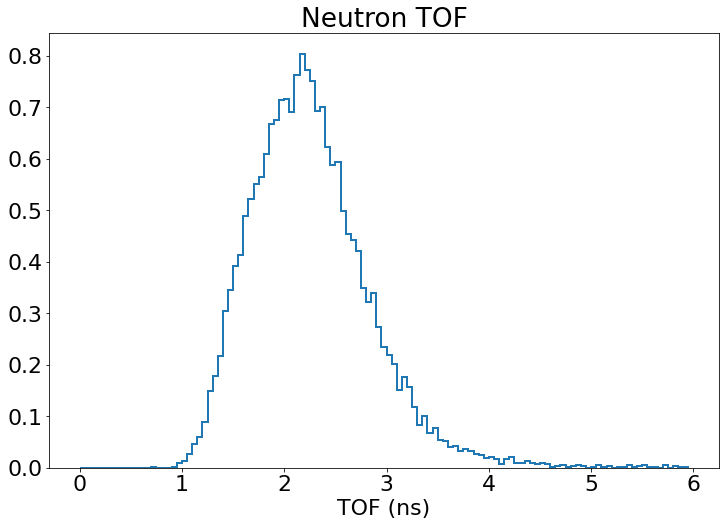

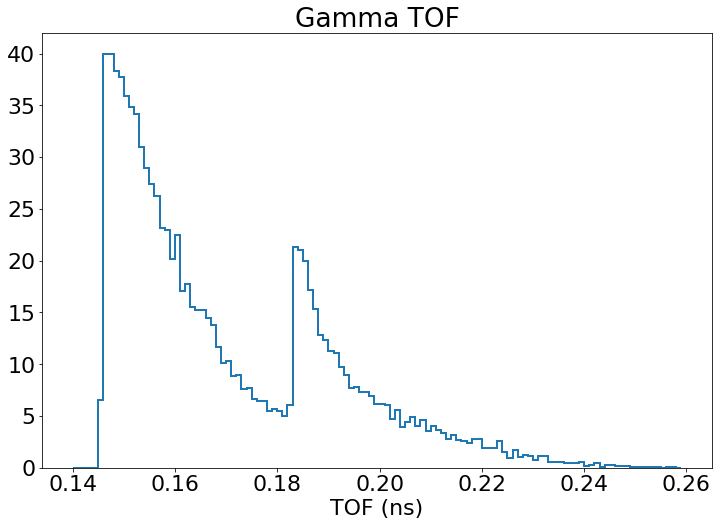

In [21]:

plt.figure()
plt.hist(final_pulses_energy[final_pulses_isN==1]);
plt.title("Neutron Energy Deposition (MeV)")

plt.figure()
plt.hist(final_pulses_energy[final_pulses_isN==0]);
plt.title("Gamma Energy Deposition (MeV)")

plt.figure()
plt.hist(final_pulses_real_times[final_pulses_isN==1],range=(0,6),bins=np.arange(0,6,0.05),density=True,histtype=u'step',linewidth=2);
plt.title("Neutron TOF")
plt.xlabel('TOF (ns)')

plt.figure()
plt.hist(final_pulses_real_times[final_pulses_isN==0],bins=np.arange(0.14,0.26,0.001),density=True,histtype=u'step',linewidth=2);
plt.title("Gamma TOF")
plt.xlabel('TOF (ns)')

## Multiplicity Check

Text(0.5, 0, 'Prompt Energy (MeV)')

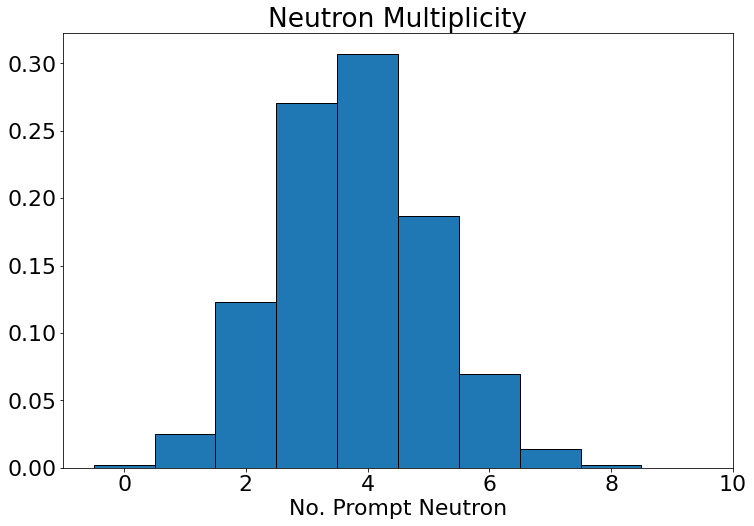

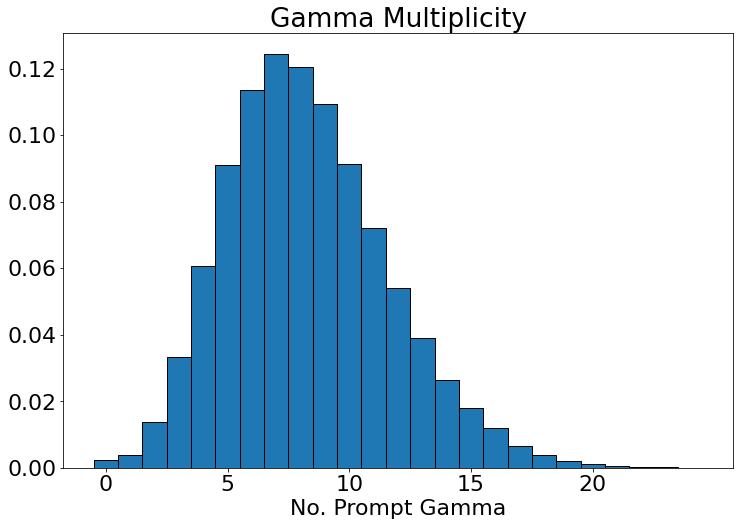

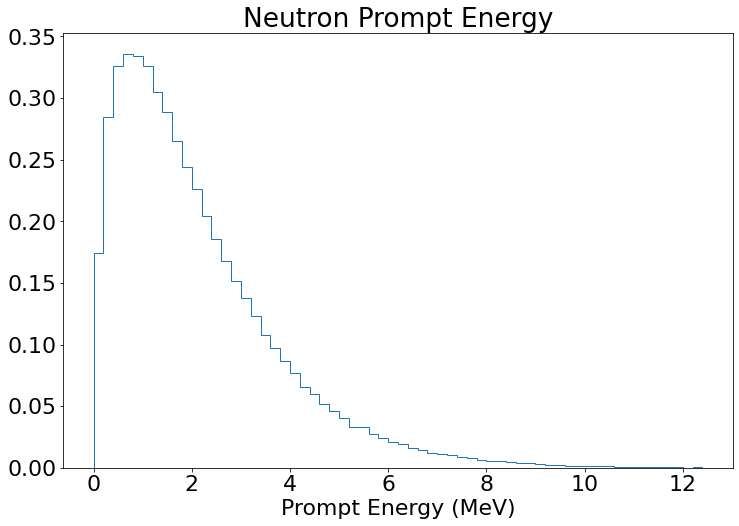

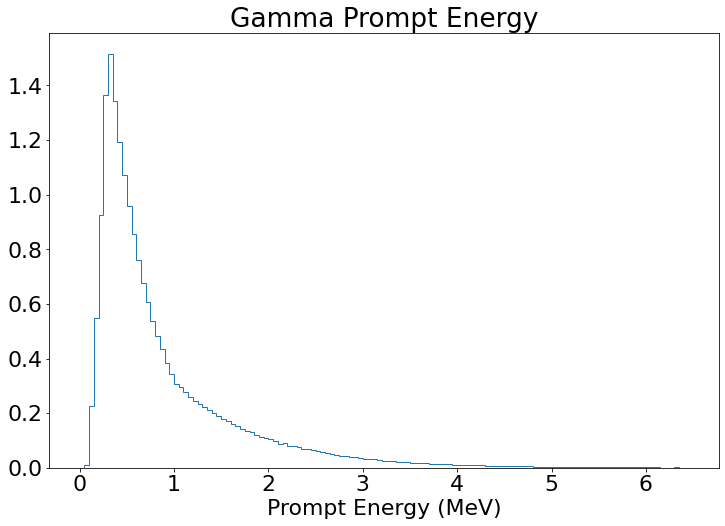

In [22]:
plt.figure()
df_temp = pd.read_csv('rossi_nt_Neutron Mul.csv',sep=',',   header=4,names=["M"])
plt.hist(df_temp["M"],bins=np.arange(-1,10)+0.5,ec="k",density=True)
plt.title("Neutron Multiplicity")
plt.xlabel("No. Prompt Neutron")

plt.figure()
df_temp = pd.read_csv('rossi_nt_Gamma Mul.csv',sep=',',   header=4,names=["M"])
plt.hist(df_temp["M"],bins=np.arange(-1,25)+0.5,ec="k",density=True)
plt.xticks(range(0,25,5))
plt.title("Gamma Multiplicity")
plt.xlabel("No. Prompt Gamma")

plt.figure()
df_temp = pd.read_csv('rossi_nt_Neutron E.csv',sep=',',   header=4,names=["E"])
plt.hist(df_temp["E"],bins=np.arange(0,12.5,0.2),density=True,histtype=u'step')
plt.title("Neutron Prompt Energy")
plt.xlabel("Prompt Energy (MeV)")

plt.figure()
df_temp = pd.read_csv('rossi_nt_Gamma E.csv',sep=',',   header=4,names=["E"])
plt.hist(df_temp["E"],bins=np.arange(0,6.5,0.05),density=True,histtype=u'step')
plt.title("Gamma Prompt Energy")
plt.xlabel("Prompt Energy (MeV)")

## Load neutron correlation between Energy and Number file

In [23]:
df_temp = pd.read_csv('rossi_nt_Neutron Occ.csv',sep=',',   header=5,names=["ID","E"])

len(df_temp["ID"].unique())

154735

In [24]:


df_temp = pd.read_csv('rossi_nt_Neutron Occ.csv',sep=',',   header=5,names=["ID","E"])
df_temp=df_temp.head(int(len(df_temp)*(50/100)))
d=dict()
for i in range(1,10):
    d[i]=[]
unique_events=df_temp["ID"].unique()
for idx,event_id in enumerate(unique_events):
    if(idx%5000==0):
        print('Progress:',round(100*idx/len(set(df_temp["ID"]))),'%')
    indices = df_temp["ID"]==event_id
    neutrons = np.sum(indices)
    d[neutrons]+=list(df_temp["E"][indices])




Progress: 0 %
Progress: 6 %
Progress: 13 %
Progress: 19 %
Progress: 26 %
Progress: 32 %
Progress: 39 %
Progress: 45 %
Progress: 52 %
Progress: 58 %
Progress: 65 %
Progress: 71 %
Progress: 78 %
Progress: 84 %
Progress: 90 %
Progress: 97 %


In [25]:
import pickle
f = open('neutron_dict.pckl', 'wb')
pickle.dump(d, f)
f.close()


1 1926
2 19224
3 62580
4 95752
5 72520
6 32028
7 7525
8 1016
9 144


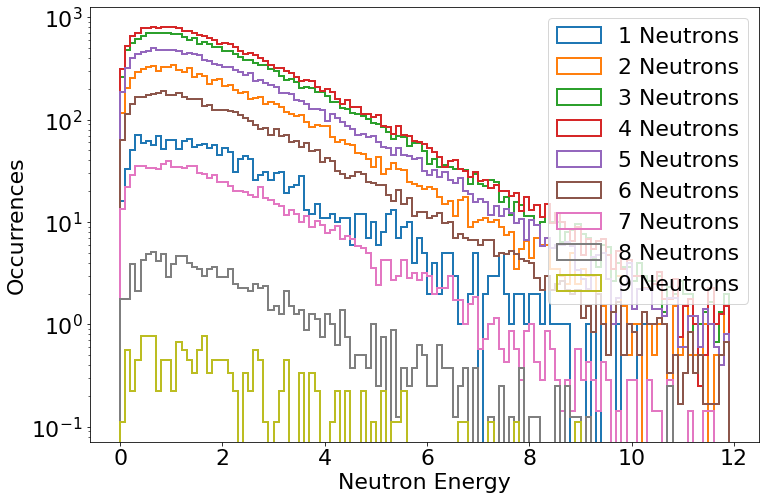

In [26]:
plt.figure()
for key,values in d.items():
    print(key, len(values))
    plt.hist(values, bins=np.arange(0,12,0.1),histtype=u'step',label = "{} Neutrons".format(key),linewidth=2,weights=1/key*np.ones((len(values),1)))
    plt.legend()
    plt.yscale('log')
plt.xlabel('Neutron Energy')
plt.ylabel('Occurrences')
ax = plt.gca()
ax.legend(fontsize=22)